# What drives the price of a car?

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

* Realign inventory to what customers value in order to boost sales.  
* Provide competitive pricing by understanding the market and customer preferences.
* Reduce operating costs by eliminating older vehicles that may require more maintenance, repairs, not as fuel efficient, and may not have the latest features that customers are looking for.
* Reduce operating costs by eliminating expensive vehicles that may take longer to sell. Thus freeing up space for vehicles that are more likely to sell. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

* Explore price, eliminate outliers that may be skewing the data
* Explore columns that may be related to price such as year, mileage, and condition.
* Remove vehicles that do not have a clean title, as they may be less desirable to customers and could be priced lower than their market value.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [328]:
#Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [329]:
# read in data
cars = pd.read_csv('data/vehicles.csv')
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [330]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [331]:
#Dropping the size column which is only 26% of our dataset.
df = cars.drop(columns=['size'])

First let's look at our given numerical data

In [332]:
df_numeric = cars.select_dtypes(include=[np.number])
df_numeric.head()

,id,price,year,odometer
0,7222695916,6000,NaN,NaN
1,7218891961,11900,NaN,NaN
2,7221797935,21000,NaN,NaN
3,7222270760,1500,NaN,NaN
4,7210384030,4900,NaN,NaN


Note: Since only 3 of our features are numeric we'll have to encode the rest of them.

# Data Cleaning

In [333]:
# We initiallly decided to drop rows where 'manufacturer' and 'model' is NaN
cars = cars.dropna(subset=['model'])
cars = cars.dropna(subset=['manufacturer'])

# However we're going to drop all rows wiht NaN values as they may skew our correlation matix.
cars = cars.dropna()

# A coupe ferrari's snuck in, let's drop.
cars = cars[cars['manufacturer'] != 'ferrari']

# Let's clean up undesirable title status. Who would want to buy a car with these titles status?
# Usually people want something reliable.  They don't want to spend a lot of money for something that will give them trouble.
remove_title_status = ['salvage', 'parts_only', 'lien', 'missing','rebuilt']
cars = cars[~cars['title_status'].isin(remove_title_status)]

# Let's remove entries that are parts only.
cars = cars[cars['title_status'] != 'parts_only']
    
# Let's drop older cars that may be less desirable to customers and could be priced lower than their market value. Also may require more maintenance, repairs, missing safety features, not as fuel efficient and cost money to store on the lot. Let's drop cars that over 30 years old.
cars = cars[cars['year'] >= 1975]

# Price to keep on the lot. Let's drop cars that are priced less than $600, that's $50/month in expenses (at least) to keep and store on the lot. 
cars = cars[cars['price'] >= 600]

# Let's get rid of cars that are priced over $120,000, as they may be outliers and skewing the data. Also may not be desirable to customers and could be priced higher than their market value.
# Anything over $120,000 is likely a luxury or exotic car,which we can analyze separately if we want to.  
cars = cars[cars['price'] <= 120000]

# Let's drop recors there manufacturer is Harley-Davidson, as they are motorcycles.  The idea is that luxury cars, motorcyles, have different features and the dealership is specialized in these areas.
cars = cars[cars['manufacturer'] != 'harley-davidson']

# Let's drop cars that have an odometer reading over 250,000 miles, as they may be less desirable to customers and could be priced lower than their market value. After 250,000. It may be time to replace the motor.
cars = cars[cars['odometer'] <= 250000]

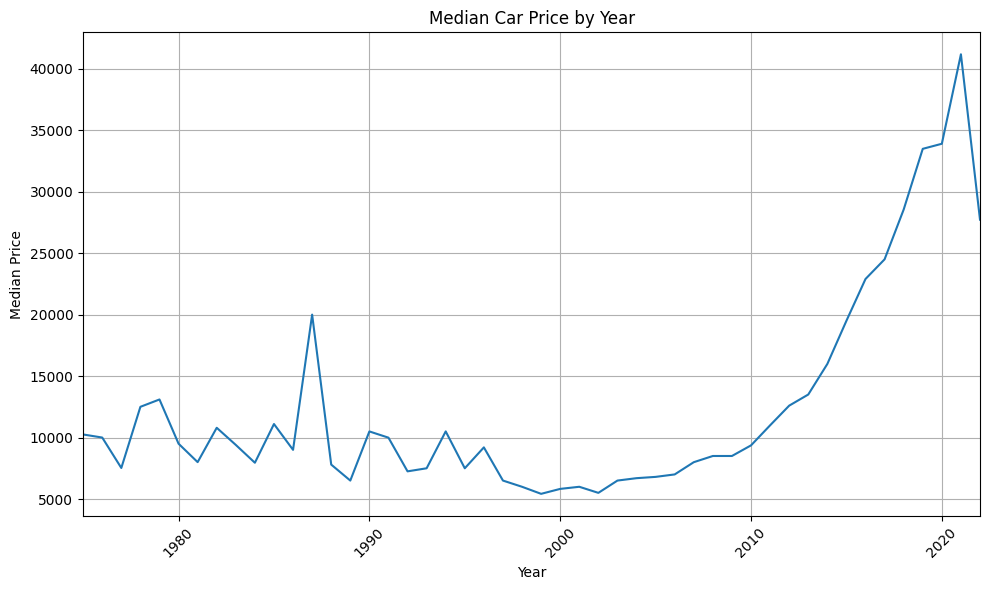

In [334]:
# Median prices by year
median_prices = cars.groupby('year')['price'].median()
plt.figure(figsize=(10, 6))
sns.lineplot(x=median_prices.index, y=median_prices.values)
plt.title('Median Car Price by Year')
plt.xlabel('Year')
plt.xlim(cars['year'].min(), cars['year'].max())
plt.ylabel('Median Price')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.savefig('images/median_price_by_year.png')
plt.show()

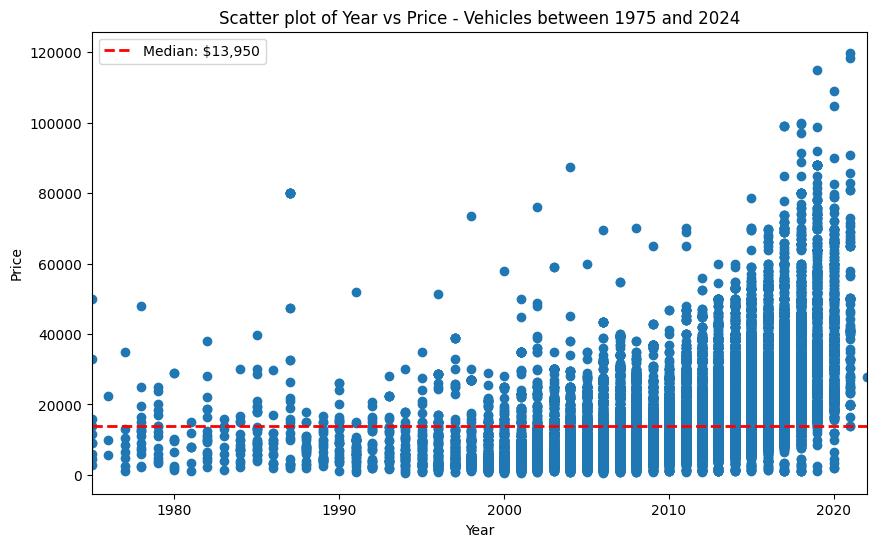

In [335]:
# Let's try to plot again after some data cleaning
#sns.scatterplot(data=cars, x='year', y='price')
median_price = cars['price'].median()

plt.figure(figsize=(10,6))
plt.scatter(cars['year'], cars['price'])
plt.xlim(cars['year'].min(), cars['year'].max())
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Scatter plot of Year vs Price - Vehicles between 1975 and 2024')
plt.axhline(y=median_price, color='red', linestyle='--', linewidth=2, label=f'Median: ${median_price:,.0f}')
plt.legend()
plt.savefig('images/cleaned_year_price_1975_2024.png')
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [336]:
# Let's do a linear regression model based on the year and price
X = cars[['year']]
y = cars['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 129741625.94371223
R^2 Score: 0.22841856639998537


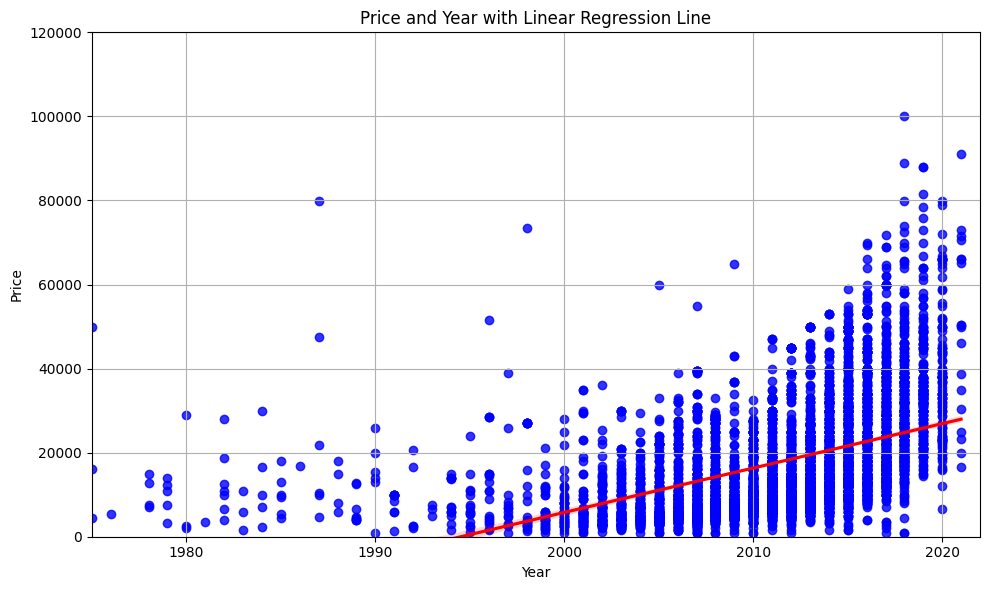

In [337]:
plt.figure(figsize=(10, 6))
sns.regplot(x=X_test['year'], y=y_test, data=cars,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlim(min(cars['year']), max(cars['year']))
plt.ylim(0, 120000)
plt.title('Price and Year with Linear Regression Line')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid()
plt.tight_layout()
plt.savefig('images/price_year__linear_regression.png')
plt.show()

In [338]:
# There's a little bit of an curve in year, price so let's try a polynomial model
X = cars[['year']]
y = cars['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)


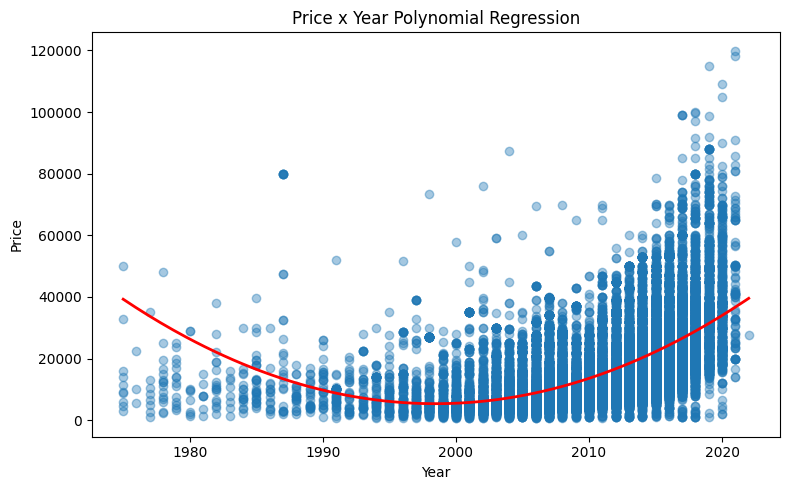

In [339]:
# Let's try plotting a polynomial models
fig, ax = plt.subplots(figsize=(8, 5))

model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('reg',  LinearRegression())
])
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

ax.scatter(X, y, alpha=0.4, label='Data')
    
X_line = np.linspace(X.min().values[0], X.max().values[0], 200).reshape(-1, 1)
X_line_df = pd.DataFrame(X_line, columns=['year'])
ax.plot(X_line_df, model.predict(X_line_df), color='red', linewidth=2)
ax.set_title('Price x Year Polynomial Regression')
ax.set_xlabel('Year')
ax.set_ylabel('Price')
plt.savefig('images/price_year_poly.png')
plt.tight_layout()
plt.show()

In [340]:
# Linear regression model on odometer and price
X = cars[['odometer']]
y = cars['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 131339494.24986714
R^2 Score: 0.21891594525276847


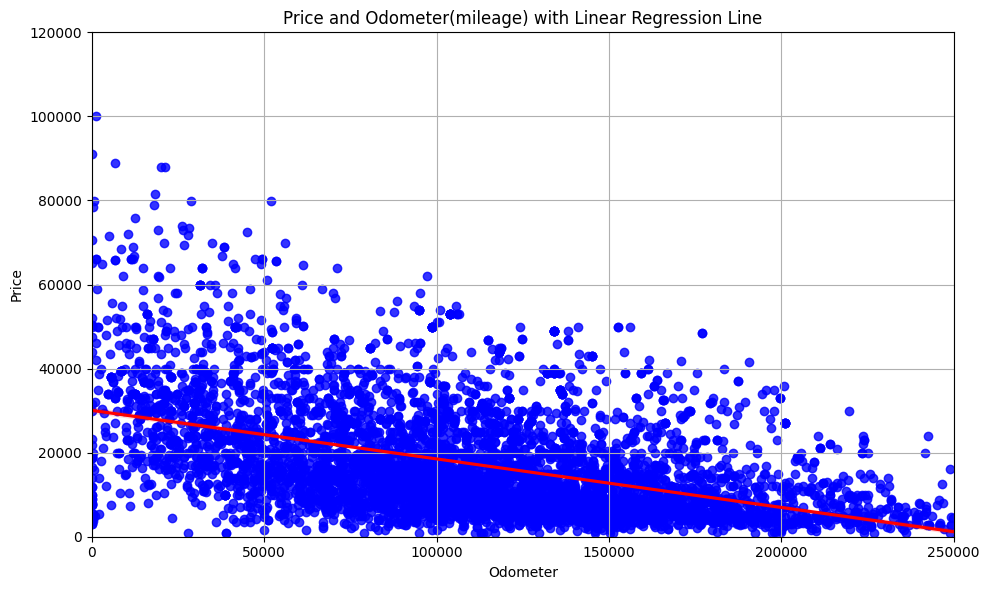

In [341]:
plt.figure(figsize=(10, 6))
sns.regplot(x=X_test['odometer'], y=y_test, data=cars,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlim(0, max(cars['odometer']))
plt.ylim(0, 120000)
plt.title('Price and Odometer(mileage) with Linear Regression Line')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.grid()
plt.tight_layout()
plt.savefig('images/price_odometer_regression.png')
plt.show()

Now let's create a correlation matrix to see if there's other features that drive price.

In [342]:
# need to convert categorical variables to numeric for our correlation matrix
cars_numeric = cars.copy()
cars_numeric = cars_numeric[(cars_numeric['price'] != 0) & (cars_numeric['price'] != 1)]
cars_numeric = cars_numeric[(cars_numeric['price'] < 100000)]
cars_numeric['price'].value_counts().sort_values()  

#bins = np.arange(0, cars_numeric['price'].max() + 5000, 5000)
#cars_numeric['bins'] = pd.cut(cars_numeric['price'], bins=bins)

cars_numeric = cars_numeric[cars_numeric['cylinders'] != 'other']
condition_mapping = {
    'new': 5,
    'like new': 4,
    'excellent': 3,
    'good': 2,
    'fair': 1,
    'salvage': 0
}
title_status_mapping = {
    'clean': 5,
    'salvage': 4,
    'rebuilt': 3,
    'lien': 2,
    'missing': 1,
    'parts only': 0
}

fuel_mapping = {
    'gas': 3,
    'diesel': 2,
    'electric': 1,
    'hybrid': 0
}
cylinders_mapping = {
    '12 cylinders': 6,
    '10 cylinders': 5,
    '8 cylinders': 4,
    '6 cylinders': 3,
    '5 cylinders': 2,
    '4 cylinders': 1,
    '3 cylinders': 0
}
drive_mapping = {
    '4wd': 2,
    'rwd': 1,
    'fwd': 0
}
#cars_numeric['bin_index'] = cars_numeric.groupby('bins', observed=True).cumcount()+1

cars_numeric['condition'] = cars_numeric['condition'].map(condition_mapping)
cars_numeric['title_status'] = cars_numeric['title_status'].map(title_status_mapping)    
cars_numeric['fuel'] = cars_numeric['fuel'].map(fuel_mapping)
cars_numeric['cylinders'] = cars_numeric['cylinders'].map(cylinders_mapping)
cars_numeric['drive'] = cars_numeric['drive'].map(drive_mapping)
cars_numeric = cars_numeric.select_dtypes(include=np.number)

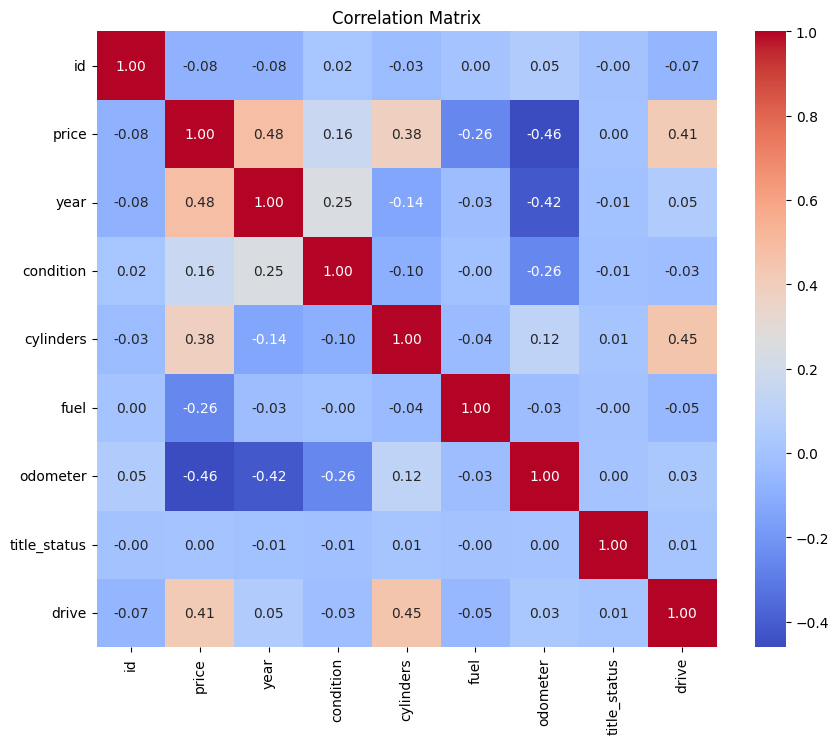

In [343]:
# Correlation matrix naive approach, via frequency encoding
corr = cars_numeric.corr()

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, fmt=".2f", cmap="coolwarm", annot=True)
plt.title('Correlation Matrix')
plt.savefig('images/correlation_matrix_cleaned.png')
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Based on the correlation matrix, and the modeling above the price is most strongly correlated with year and odometer. The other value that seems to have a strong correlation is cylinders.  Let's dive deeper there.

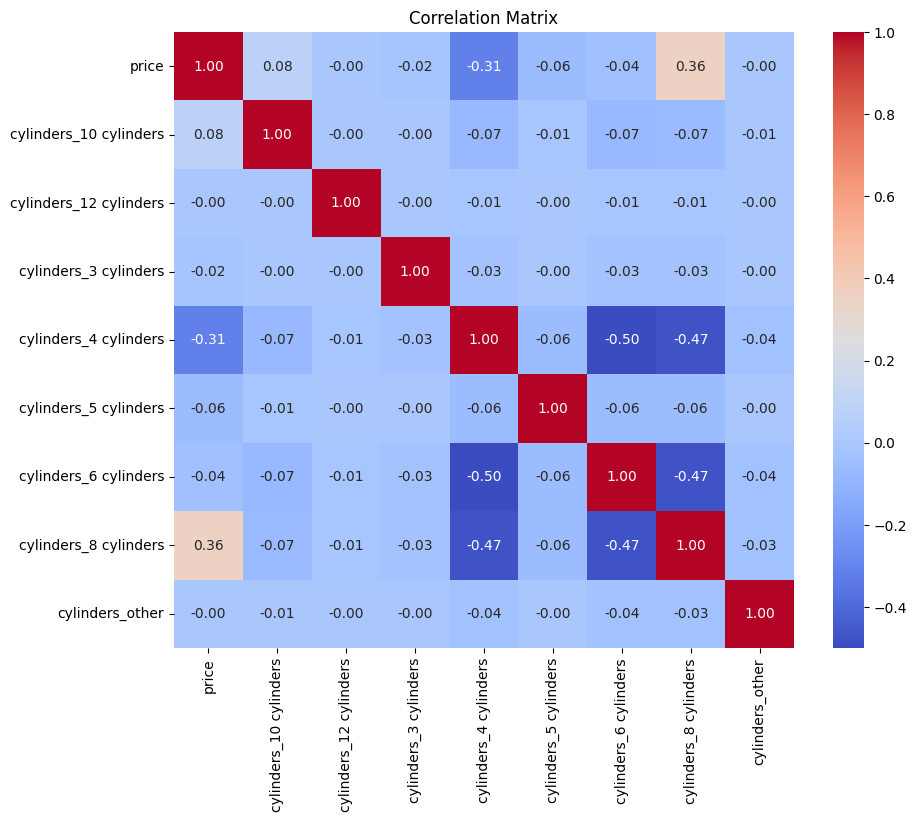

In [344]:
cars_corr = cars[['price','cylinders']]
df = pd.get_dummies(cars_corr, columns=['cylinders'])

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), fmt=".2f", cmap="coolwarm", annot=True)
plt.title('Correlation Matrix')
plt.savefig('images/correlation_matrix_cleaned.png')
plt.show()

It appears that 8 cylinder vehicles are a popular choice among customers.

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29855 entries, 215 to 426833
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   price                   29855 non-null  int64
 1   cylinders_10 cylinders  29855 non-null  bool 
 2   cylinders_12 cylinders  29855 non-null  bool 
 3   cylinders_3 cylinders   29855 non-null  bool 
 4   cylinders_4 cylinders   29855 non-null  bool 
 5   cylinders_5 cylinders   29855 non-null  bool 
 6   cylinders_6 cylinders   29855 non-null  bool 
 7   cylinders_8 cylinders   29855 non-null  bool 
 8   cylinders_other         29855 non-null  bool 
dtypes: bool(8), int64(1)
memory usage: 699.7 KB


In [346]:
cars.query('cylinders == "8 cylinders"').sort_values('price', ascending=False).head(20)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
419656,7317021019,madison,119900,2021.0,chevrolet,corvette,good,8 cylinders,gas,601.0,clean,automatic,1G1YC2D49M5106953,rwd,mid-size,coupe,red,wi
44736,7312007761,palm springs,118300,2021.0,rover,supercharged,new,8 cylinders,gas,5000.0,clean,automatic,SALGS2SE6MA422344,4wd,full-size,SUV,grey,ca
278384,7315248956,rochester,115000,2019.0,bmw,850i,like new,8 cylinders,gas,3800.0,clean,automatic,WBABC4C51KBU96459,4wd,mid-size,coupe,blue,ny
113451,7314757008,south florida,109000,2020.0,chevrolet,corvette lt3,like new,8 cylinders,gas,2107.0,clean,automatic,1G1Y82D40L5102449,rwd,mid-size,coupe,white,fl
4826,7316436488,tuscaloosa,104900,2020.0,bmw,m805i,excellent,8 cylinders,gas,9000.0,clean,automatic,WBAGV8C04LBP48895,4wd,full-size,sedan,black,al
35419,7315632211,los angeles,99700,2018.0,ford,super duty f-250 srw,excellent,8 cylinders,diesel,31484.0,clean,automatic,1FT7W2BT9JEB88098,4wd,full-size,pickup,grey,ca
5064,7316497061,anchorage / mat-su,98995,2017.0,porsche,panamera turbo,excellent,8 cylinders,gas,38562.0,clean,automatic,WP0AF2A72HL153094,4wd,full-size,hatchback,brown,ak
6513,7309994679,anchorage / mat-su,98995,2017.0,porsche,panamera turbo,excellent,8 cylinders,gas,38562.0,clean,automatic,WP0AF2A72HL153094,4wd,full-size,hatchback,brown,ak
7647,7302779934,anchorage / mat-su,98995,2017.0,porsche,panamera turbo,excellent,8 cylinders,gas,38562.0,clean,automatic,WP0AF2A72HL153094,4wd,full-size,hatchback,brown,ak
5190,7315923139,anchorage / mat-su,98750,2019.0,ford,f350 super duty lariat,like new,8 cylinders,diesel,47100.0,clean,automatic,1FT8W3BT8KEC73929,4wd,full-size,truck,black,ak


More specifically the porche panamera turbo and ford trucks. 

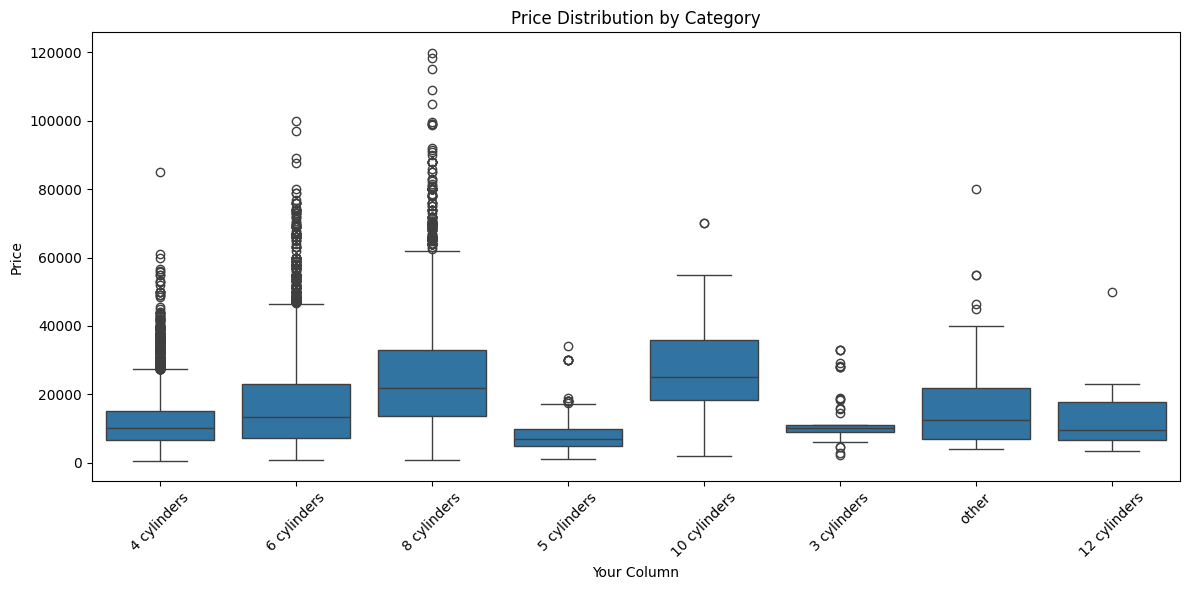

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cylinders', y='price', data=cars_corr)

plt.title('Price Distribution by Category')
plt.xlabel('Your Column')
plt.ylabel('Price')
plt.xticks(rotation=45)  # rotate labels if there are many categories
plt.savefig('images/box_cylinders.png')
plt.tight_layout()
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Moving this all to the the report. (README.md)